In [13]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import math
import matplotlib.pyplot as plt

# Task 1

Apply the normalization on the training and test data

In [2]:
train_data = MNIST('./data', train=True, transform=ToTensor(), download=True)
test_data = MNIST('./data', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
data, label = next(iter(train_loader))
test_data, test_label = next(iter(test_loader))

data, label, test_data, test_label = data.numpy().squeeze().reshape(data.shape[0],
                                                                    -1), label.numpy(), test_data.numpy().squeeze().reshape(
    test_data.shape[0], -1), test_label.numpy()
print('shape train: data-{} label-{}, test: data-{} label-{}'.format(data.shape, label.shape, test_data.shape,
                                                                     test_label.shape))

# normalize
data_mean = np.mean(data, axis=1)
data_std = np.std(data, axis=1)

normalized_data = np.zeros(data.shape)
for idx, data_elem in enumerate(data):
    normalized_data[idx] = (data_elem - data_mean[idx]) / data_std[idx]
data = normalized_data

del normalized_data

test_data_mean = np.mean(test_data, axis=1)
test_data_std = np.std(test_data, axis=1)

normalized_test_data = np.zeros(test_data.shape)
for idx, test_data_elem in enumerate(test_data):
    normalized_test_data[idx] = (test_data_elem - test_data_mean[idx]) / test_data_std[idx]
test_data = normalized_test_data

del normalized_test_data

# add bias
bias = np.ones((data.shape[0], 1))
data = np.concatenate([data, bias], axis=-1)

bias = np.ones((test_data.shape[0], 1))
test_data = np.concatenate([test_data, bias], axis=-1)

print('normalized data shape: {}, normalized test data shape: {}'.format(data.shape, test_data.shape))

# format labels
condition_mask = 5 <= label
condition_mask_ = label <= 9
condition_mask = condition_mask & condition_mask_
label = np.zeros(label.shape)
label[condition_mask] = 1

condition_mask = 5 <= test_label
condition_mask_ = test_label <= 9
condition_mask = condition_mask & condition_mask_
test_label = np.zeros(test_label.shape)
test_label[condition_mask] = 1

print('label shape: {}, test label shape: {}'.format(label.shape, test_label.shape))

shape train: data-(60000, 784) label-(60000,), test: data-(10000, 784) label-(10000,)
normalized data shape: (60000, 785), normalized test data shape: (10000, 785)
label shape: (60000,), test label shape: (10000,)


# Task 2

Train a linear classifier $\hat{y} = \boldsymbol{v}^\top\boldsymbol{x}$ and quadratic loss. Report its test accuracy

- Let's assume our weight vector is called $\boldsymbol{\theta} \in \mathbb{R}^d$ and our data is represented as $\boldsymbol{X} \in \mathbb{R}^{n\times d}$. Also, the labels of linear classifier is represented as $\boldsymbol{y} \in \mathbb{R}^n$. Then, the loss can be denoted as $\mathcal{L} = \|\boldsymbol{y} - \boldsymbol{X}\boldsymbol{\theta}\|^2$. Therefore, the gradient is $\nabla\mathcal{L} = -\boldsymbol{X}^\top(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{\theta})$.

In [3]:
# init theta vector
learning_rate = 0.00000001
num_of_iter = 800
theta = np.zeros((data.shape[1], 1))

for _ in range(num_of_iter):
    loss = np.linalg.norm(label[:, np.newaxis] - (data @ theta)) ** 2
    gradient = -2 * np.transpose(data) @ (label[:, np.newaxis] - (data @ theta))
    theta = theta - learning_rate * gradient
    if (_ + 1) % 40 == 0:
        predictions = ((test_data @ theta) > 0).astype(int)
        acc = np.sum((test_label[:, np.newaxis] == predictions).astype(int)) / len(test_label)
        print('iteration: {}, loss: {}, acc: {}'.format(_ + 1, loss, acc))

predictions = ((test_data @ theta) > 0).astype(int)
acc = np.sum((test_label[:, np.newaxis] == predictions).astype(int)) / len(test_label)
print('resulting accuracy: {}'.format(acc))

iteration: 40, loss: 10160.543226186765, acc: 0.492
iteration: 80, loss: 9146.96106903887, acc: 0.5085
iteration: 120, loss: 8688.215429540976, acc: 0.5233
iteration: 160, loss: 8439.075230055096, acc: 0.5338
iteration: 200, loss: 8283.760216824543, acc: 0.541
iteration: 240, loss: 8175.183624937793, acc: 0.5465
iteration: 280, loss: 8092.401973300382, acc: 0.55
iteration: 320, loss: 8025.304365064976, acc: 0.5533
iteration: 360, loss: 7968.599838538435, acc: 0.5543
iteration: 400, loss: 7919.294937107848, acc: 0.5556
iteration: 440, loss: 7875.567156077952, acc: 0.557
iteration: 480, loss: 7836.230546317329, acc: 0.5581
iteration: 520, loss: 7800.467182021914, acc: 0.5586
iteration: 560, loss: 7767.684610916767, acc: 0.5591
iteration: 600, loss: 7737.436112169475, acc: 0.5591
iteration: 640, loss: 7709.373800336907, acc: 0.5589
iteration: 680, loss: 7683.219704510451, acc: 0.5586
iteration: 720, loss: 7658.747122118823, acc: 0.5587
iteration: 760, loss: 7635.7680969212015, acc: 0.559


# Task 3

Train a neural network classifier with quadratic loss. Plot the progress of the test and training accuracy (y-axis) as a function of the iteration counter t (x-axis)

In [20]:
# forward
def _relu(input_matrix):
    result = np.zeros(input_matrix.shape)
    pos_mask = input_matrix > 0
    result[pos_mask] = input_matrix[pos_mask]
    return result

def forward(input_vector, inner_weight, out_weight, ctx, forward_id):
    out = inner_weight @ input_vector
    out = _relu(out)
    if ctx:
        ctx[forward_id]['after_relu'] = out
    out = np.transpose(out_weight) @ out
    if ctx:
        ctx[forward_id]['pred'] = out[0, 0]
    return out
    # out = input_matrix @ np.transpose(inner_weight)
    # out = _relu(out)
    # ctx['after_relu'] = out
    # out =  out @ out_weight
    # ctx['out'] = out
    # return out

# criterion
def criterion(labels, preds):
    _loss = 0
    for _idx in range(labels.shape[0]):
        _loss = _loss + (labels[_idx, 0] - preds[_idx, 0]) ** 2
    return _loss / labels.shape[0]


# backward
def backward(input_data, labels, inner_weight, out_weight, ctx):
    grad_out_weight = np.zeros(out_weight.shape)
    grad_inner_weight = np.zeros(inner_weight.shape)
    for _idx in range(input_data.shape[0]):
        grad_out_weight = grad_out_weight + ((-2 * (labels[_idx, 0] - ctx[_idx]['pred'])) * ctx[_idx]['after_relu'])
        relu_grad = ctx[_idx]['after_relu']
        relu_grad[ctx[_idx]['after_relu'] > 0] = 1
        grad_inner_weight = grad_inner_weight + (-2 * (labels[_idx, 0] - ctx[_idx]['pred'])) * ((out_weight * relu_grad) @ input_data[_idx][np.newaxis, :])
    return grad_inner_weight / input_data.shape[0], grad_out_weight / input_data.shape[0]

# optimizer
def optimizer(inner_weight, out_weight, grad_inner_weight, grad_out_weight, _learning_rate):
    inner_weight = inner_weight - (_learning_rate * grad_inner_weight)
    out_weight = out_weight - (_learning_rate * grad_out_weight)
    return inner_weight, out_weight

def apply_forward(input_row, inner_weight, out_weight):
    input_vector = input_row[:, np.newaxis]
    out = forward(input_vector, inner_weight, out_weight, None, None)[0, 0]
    if out > 0:
        return 1
    else:
        return 0

# train
def train(_data, _label, _test_data, _test_label, _k, _learning_rate, num_of_epochs=10, batch_size=10):
    # init weights
    inner_weight = np.random.normal(0, 1/_data.shape[1], size=(_k, _data.shape[1]))
    out_weight = np.random.normal(0, 1/_k, size=(_k, 1))

    #train
    running_loss = []
    running_train_acc = []
    running_test_acc = []
    for epoch in range(num_of_epochs):
        # data split idx
        idx_permutation = np.random.permutation(_data.shape[0])
        tot_loss = 0
        tot_train_acc = 0
        tot_test_acc = 0
        for data_iter in range(0, _data.shape[0], 10):
            batch_idx = idx_permutation[data_iter:(data_iter + batch_size)]
            batch_data, batch_label = _data[batch_idx], _label[batch_idx]
            batch_label = batch_label[:, np.newaxis]
            ctx = [{} for _ in range(batch_size)]
            out = np.zeros((batch_size, 1))
            for batch_data_idx, batch_data_elem in enumerate(batch_data):
                out[batch_data_idx, 0] = forward(batch_data_elem[:, np.newaxis], inner_weight, out_weight, ctx, batch_data_idx)
            _loss = criterion(batch_label, out)
            running_loss.append(_loss)
            tot_loss += _loss
            grad_inner_weight, grad_out_weight = backward(batch_data, batch_label, inner_weight, out_weight, ctx)
            inner_weight, out_weight = optimizer(inner_weight, out_weight, grad_inner_weight, grad_out_weight, _learning_rate)

            # accuracy
            if ((data_iter / 10) + 1) % 1000 == 0:
                pred_out = np.apply_along_axis(apply_forward, 1, _data, inner_weight, out_weight)
                _acc = np.sum((_label == pred_out).astype(int)) / _data.shape[0]
                tot_train_acc += _acc
                running_train_acc.append(_acc)

                pred_out = np.apply_along_axis(apply_forward, 1, _test_data, inner_weight, out_weight)
                _acc = np.sum((_test_label == pred_out).astype(int)) / _test_data.shape[0]
                tot_test_acc += _acc
                running_test_acc.append(_acc)
        print('epoch: {}, loss: {}, acc: {}, test_acc: {}'.format(epoch, tot_loss / (_data.shape[0] / 10), tot_train_acc / (_data.shape[0] / (10 * 1000)), tot_test_acc / (_data.shape[0] / (10 * 1000))))

    return running_loss, running_train_acc, running_test_acc

def plot_loss_acc(running_loss, running_train_acc, running_test_acc):
    plt.figure(figsize=(10, 20))
    plt.subplot(311)
    plt.title('loss vs. iterations')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.plot(list(range(len(running_loss))), running_loss)
    z_arg = np.polyfit(list(range(len(running_loss))), running_loss, 2)
    p_arg = np.poly1d(z_arg)
    plt.plot(list(range(len(running_loss))), p_arg(list(range(len(running_loss)))))

    plt.subplot(312)
    plt.title('train acc vs. iterations')
    plt.xlabel('iteration')
    plt.ylabel('train acc')
    plt.plot(list(range(len(running_train_acc))), running_train_acc)
    z_arg = np.polyfit(list(range(len(running_train_acc))), running_train_acc, 2)
    p_arg = np.poly1d(z_arg)
    plt.plot(list(range(len(running_train_acc))), p_arg(list(range(len(running_train_acc)))))
    plt.subplot(313)
    plt.title('test acc vs. iterations')
    plt.xlabel('iteration')
    plt.ylabel('test acc')
    plt.plot(list(range(len(running_test_acc))), running_test_acc)
    z_arg = np.polyfit(list(range(len(running_test_acc))), running_test_acc, 2)
    p_arg = np.poly1d(z_arg)
    plt.plot(list(range(len(running_test_acc))), p_arg(list(range(len(running_test_acc)))))
    plt.show()

## Task 3.1 (k=5)

In [5]:
running_loss_train_5, running_acc_train_5, running_acc_test_5 = train(data, label, test_data, test_label, 5, 0.01)

epoch: 0, loss: 0.10083851038276366, acc: 0.7136722222222223, test_acc: 0.71195
epoch: 1, loss: 0.08432273682670569, acc: 0.7184750000000001, test_acc: 0.7163166666666667
epoch: 2, loss: 0.08191213863526461, acc: 0.7576694444444444, test_acc: 0.7566666666666667
epoch: 3, loss: 0.0809115002883735, acc: 0.7412916666666667, test_acc: 0.7392833333333334
epoch: 4, loss: 0.0801158819314698, acc: 0.7280611111111112, test_acc: 0.72635
epoch: 5, loss: 0.07943498114754001, acc: 0.7419861111111111, test_acc: 0.7407499999999999
epoch: 6, loss: 0.07935184026250743, acc: 0.7150888888888889, test_acc: 0.7132833333333334
epoch: 7, loss: 0.07826042985864222, acc: 0.7463694444444444, test_acc: 0.7463166666666666
epoch: 8, loss: 0.07238630777515696, acc: 0.7504083333333332, test_acc: 0.7521833333333334
epoch: 9, loss: 0.06985166208631682, acc: 0.7615250000000001, test_acc: 0.7616166666666667


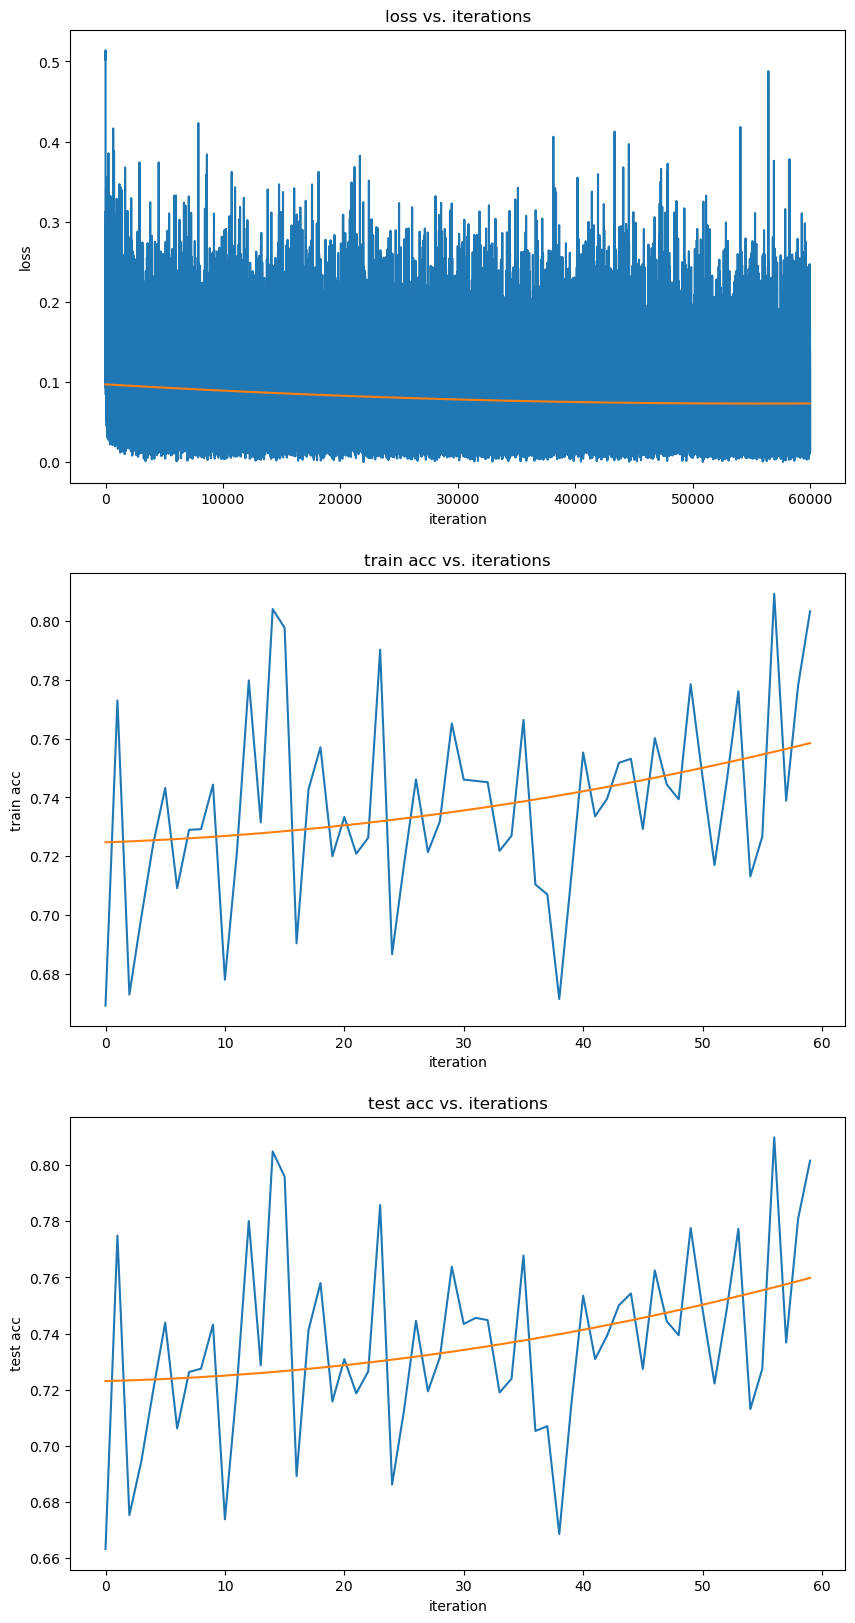

In [21]:
plot_loss_acc(running_loss_train_5, running_acc_train_5, running_acc_test_5)

## Task 3.1 (k=40)

In [6]:
running_loss_train_40, running_acc_train_40, running_acc_test_40 = train(data, label, test_data, test_label, 40, 0.001)

epoch: 0, loss: 0.06422474213785698, acc: 0.7011666666666668, test_acc: 0.6984333333333334
epoch: 1, loss: 0.035677789656917584, acc: 0.6702527777777778, test_acc: 0.6702166666666667
epoch: 2, loss: 0.03077649581299278, acc: 0.6946499999999999, test_acc: 0.6931666666666666
epoch: 3, loss: 0.028168811500765785, acc: 0.6835805555555555, test_acc: 0.685
epoch: 4, loss: 0.02624007778129908, acc: 0.7098916666666666, test_acc: 0.7103833333333333
epoch: 5, loss: 0.024882122421256803, acc: 0.6977277777777777, test_acc: 0.6984166666666667
epoch: 6, loss: 0.02376595957772662, acc: 0.6999194444444443, test_acc: 0.7008833333333332
epoch: 7, loss: 0.02300237523463321, acc: 0.7044916666666666, test_acc: 0.7026166666666667
epoch: 8, loss: 0.02223744440911818, acc: 0.7203305555555556, test_acc: 0.7202666666666667
epoch: 9, loss: 0.021638838967686085, acc: 0.6837833333333334, test_acc: 0.6825333333333333


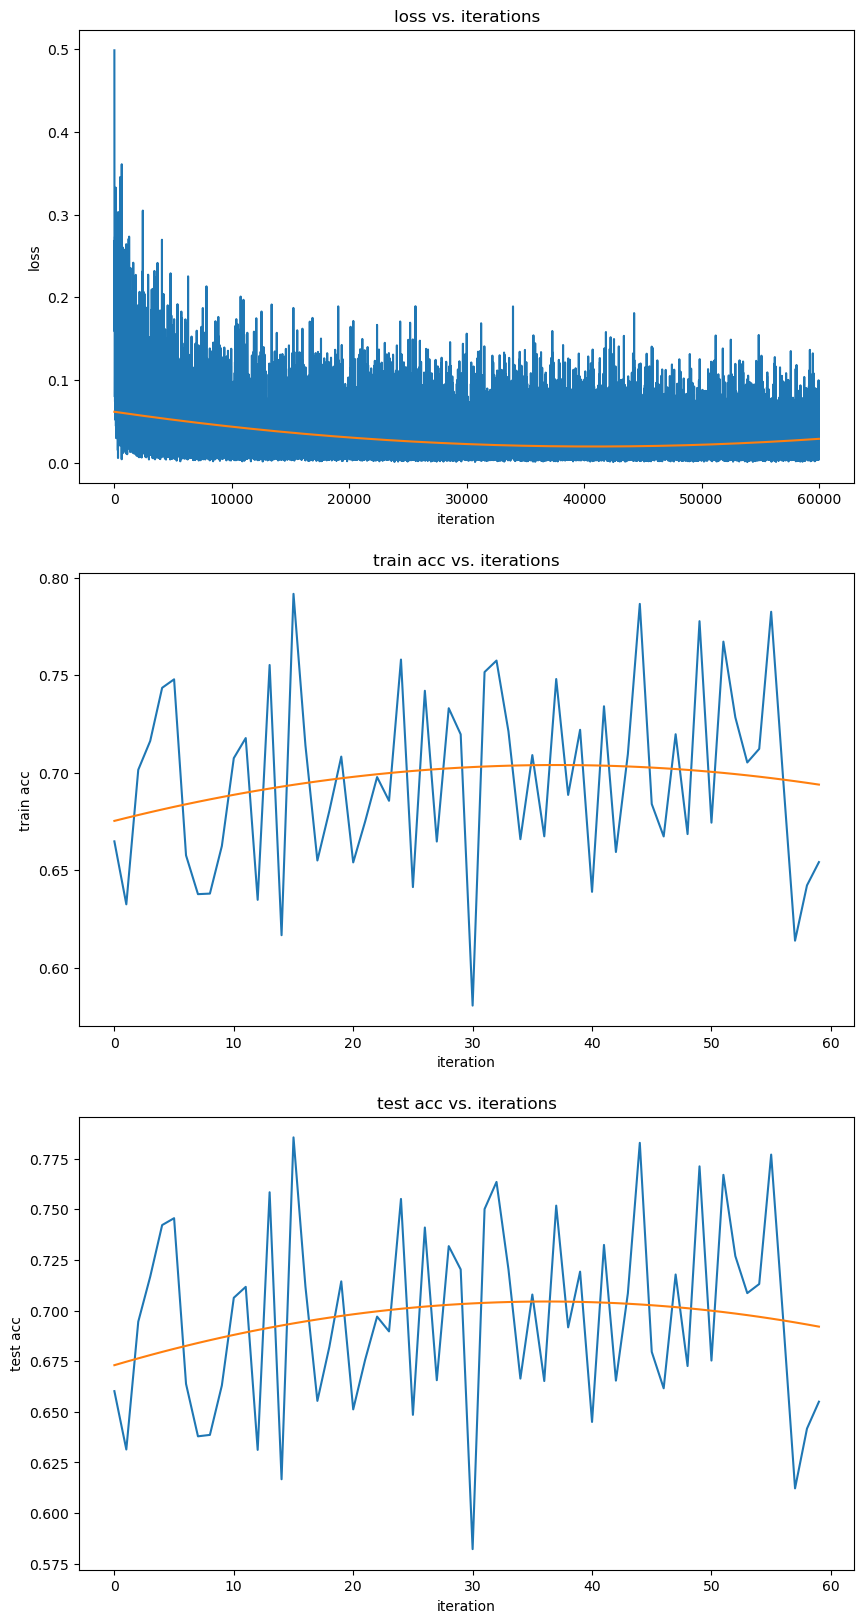

In [22]:
plot_loss_acc(running_loss_train_40, running_acc_train_40, running_acc_test_40)

## Task 3.1 (k=200)

In [7]:
running_loss_train_200, running_acc_train_200, running_acc_test_200 = train(data, label, test_data, test_label, 200, 0.01)

epoch: 0, loss: 0.061044106477189664, acc: 0.6516111111111111, test_acc: 0.6494333333333334
epoch: 1, loss: 0.031323306688646094, acc: 0.7300555555555556, test_acc: 0.7252166666666667
epoch: 2, loss: 0.02586004709150506, acc: 0.695236111111111, test_acc: 0.6956333333333333
epoch: 3, loss: 0.022550654833050767, acc: 0.6919944444444446, test_acc: 0.6903833333333332
epoch: 4, loss: 0.020397335593433576, acc: 0.6708472222222223, test_acc: 0.6721666666666667
epoch: 5, loss: 0.01892567887243248, acc: 0.7132555555555555, test_acc: 0.7120666666666667
epoch: 6, loss: 0.017553473978127985, acc: 0.7085277777777779, test_acc: 0.7085833333333333
epoch: 7, loss: 0.01644701067215665, acc: 0.7272055555555554, test_acc: 0.7267666666666667
epoch: 8, loss: 0.015604611577562376, acc: 0.7216583333333334, test_acc: 0.7229666666666666
epoch: 9, loss: 0.014803285365631089, acc: 0.7164527777777777, test_acc: 0.7161666666666667


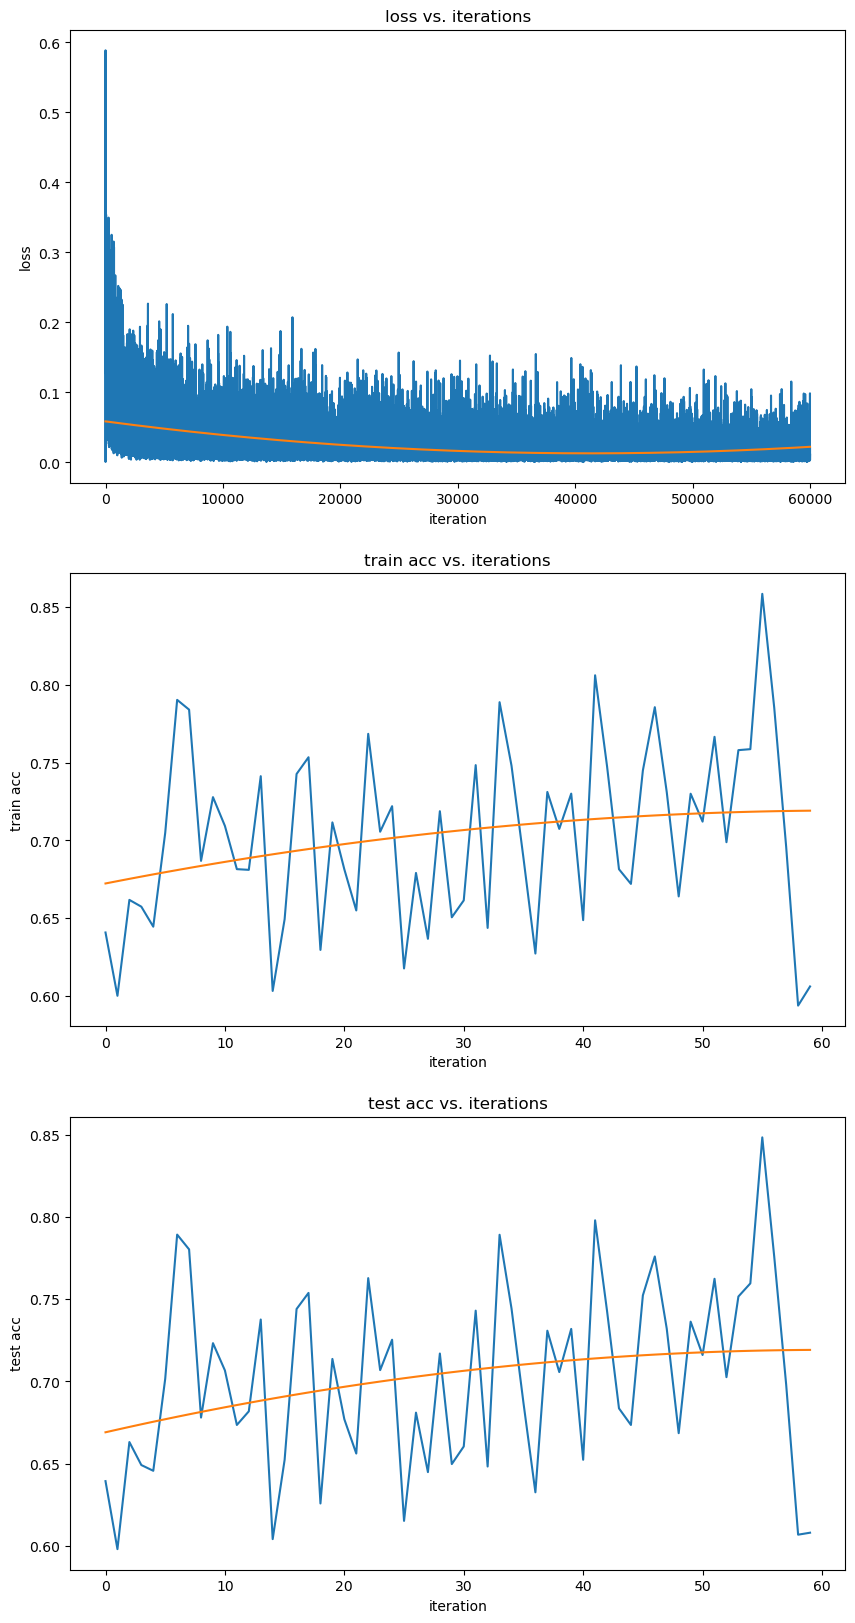

In [23]:
plot_loss_acc(running_loss_train_200, running_acc_train_200, running_acc_test_200)

As it can be seen the figures, the accuracy did not significantly change when the k value increases. However, when the feature size increases, the training process became more stable based on loss graphs.

# Task 4

Train a neural network classifier with logistic loss. Plot the progress of the test and training accuracy (y-axis) as a function of the iteration counter t (x-axis)

In [8]:
def _relu_logistic(input_matrix):
    result = np.zeros(input_matrix.shape)
    pos_mask = input_matrix > 0
    result[pos_mask] = input_matrix[pos_mask]
    return result

def forward_logistic(input_vector, inner_weight, out_weight, ctx, forward_id):
    out = inner_weight @ input_vector
    out = _relu(out)
    if ctx:
        ctx[forward_id]['after_relu'] = out
    out = np.transpose(out_weight) @ out
    if ctx:
        ctx[forward_id]['pred'] = out[0, 0]
    return out
    # out = input_matrix @ np.transpose(inner_weight)
    # out = _relu(out)
    # ctx['after_relu'] = out
    # out =  out @ out_weight
    # ctx['out'] = out
    # return out

# criterion
def criterion_logistic(labels, preds):
    _loss = 0
    for _idx in range(labels.shape[0]):
        error = (-1 * labels[_idx, 0] * math.log(_sigmoid(preds[_idx, 0]))) - ((1 - labels[_idx, 0]) * math.log(1 - _sigmoid(preds[_idx, 0])))
        _loss = _loss + error
    return _loss / labels.shape[0]


def _sigmoid(elem):
    return 1 / (1 - math.exp(-1 * elem))

# backward
def backward_logistic(input_data, labels, inner_weight, out_weight, ctx):
    grad_out_weight = np.zeros(out_weight.shape)
    grad_inner_weight = np.zeros(inner_weight.shape)
    for _idx in range(input_data.shape[0]):
        grad_error = (-1 * labels[_idx, 0] * (1 - _sigmoid(ctx[_idx]['pred']))) - ((1 - labels[_idx, 0]) * _sigmoid(ctx[_idx]['pred']))
        grad_out_weight = grad_out_weight + (grad_error * ctx[_idx]['after_relu'])
        relu_grad = ctx[_idx]['after_relu']
        relu_grad[ctx[_idx]['after_relu'] > 0] = 1
        grad_inner_weight = grad_inner_weight + grad_error * ((out_weight * relu_grad) @ input_data[_idx][np.newaxis, :])
    return grad_inner_weight / input_data.shape[0], grad_out_weight / input_data.shape[0]

# optimizer
def optimizer_logistic(inner_weight, out_weight, grad_inner_weight, grad_out_weight, _learning_rate):
    inner_weight = inner_weight - (_learning_rate * grad_inner_weight)
    out_weight = out_weight - (_learning_rate * grad_out_weight)
    return inner_weight, out_weight

def apply_forward_logistic(input_row, inner_weight, out_weight):
    input_vector = input_row[:, np.newaxis]
    out = forward(input_vector, inner_weight, out_weight, None, None)[0, 0]
    if out > 0:
        return 1
    else:
        return 0

# train
def train_logistic(_data, _label, _test_data, _test_label, _k, _learning_rate, num_of_epochs=10, batch_size=10):
    # init weights
    inner_weight = np.random.normal(0, 1/_data.shape[1], size=(_k, _data.shape[1]))
    out_weight = np.random.normal(0, 1/_k, size=(_k, 1))

    #train
    running_loss = []
    running_train_acc = []
    running_test_acc = []
    for epoch in range(num_of_epochs):
        # data split idx
        idx_permutation = np.random.permutation(_data.shape[0])
        tot_loss = 0
        tot_train_acc = 0
        tot_test_acc = 0
        for data_iter in range(0, _data.shape[0], 10):
            batch_idx = idx_permutation[data_iter:(data_iter + batch_size)]
            batch_data, batch_label = _data[batch_idx], _label[batch_idx]
            batch_label = batch_label[:, np.newaxis]
            ctx = [{} for _ in range(batch_size)]
            out = np.zeros((batch_size, 1))
            for batch_data_idx, batch_data_elem in enumerate(batch_data):
                out[batch_data_idx, 0] = forward(batch_data_elem[:, np.newaxis], inner_weight, out_weight, ctx, batch_data_idx)
            _loss = criterion(batch_label, out)
            running_loss.append(_loss)
            tot_loss += _loss
            grad_inner_weight, grad_out_weight = backward(batch_data, batch_label, inner_weight, out_weight, ctx)
            inner_weight, out_weight = optimizer(inner_weight, out_weight, grad_inner_weight, grad_out_weight, _learning_rate)

            # accuracy
            if ((data_iter / 10) + 1) % 1000 == 0:
                pred_out = np.apply_along_axis(apply_forward_logistic, 1, _data, inner_weight, out_weight)
                _acc = np.sum((_label == pred_out).astype(int)) / _data.shape[0]
                tot_train_acc += _acc
                running_train_acc.append(_acc)

                pred_out = np.apply_along_axis(apply_forward_logistic, 1, _test_data, inner_weight, out_weight)
                _acc = np.sum((_test_label == pred_out).astype(int)) / _test_data.shape[0]
                tot_test_acc += _acc
                running_test_acc.append(_acc)
        print('epoch: {}, loss: {}, acc: {}, test_acc: {}'.format(epoch, tot_loss / (_data.shape[0] / 10), tot_train_acc / (_data.shape[0] / (10 * 1000)), tot_test_acc / (_data.shape[0] / (10 * 1000))))

    return running_loss, running_train_acc, running_test_acc

In [9]:
running_loss_train_5_logistic, running_acc_train_5_logistic, running_acc_test_5_logistic = train_logistic(data, label, test_data, test_label, 5, 0.01)

epoch: 0, loss: 0.09219014650251192, acc: 0.5754750000000001, test_acc: 0.5710000000000001
epoch: 1, loss: 0.06392693767708851, acc: 0.6730583333333334, test_acc: 0.6747666666666667
epoch: 2, loss: 0.05974322778913837, acc: 0.6962444444444444, test_acc: 0.6967833333333333
epoch: 3, loss: 0.0581060263156406, acc: 0.7036111111111113, test_acc: 0.7047333333333333
epoch: 4, loss: 0.05714266601758725, acc: 0.7260666666666666, test_acc: 0.7250166666666668
epoch: 5, loss: 0.056605546377192194, acc: 0.7264555555555555, test_acc: 0.7261666666666667
epoch: 6, loss: 0.05596941469119708, acc: 0.7144611111111111, test_acc: 0.7141666666666667
epoch: 7, loss: 0.055598484631003815, acc: 0.7168444444444445, test_acc: 0.7147166666666666
epoch: 8, loss: 0.055215956447003306, acc: 0.7239777777777778, test_acc: 0.7247499999999999
epoch: 9, loss: 0.054819161325354276, acc: 0.7542499999999999, test_acc: 0.7542333333333334


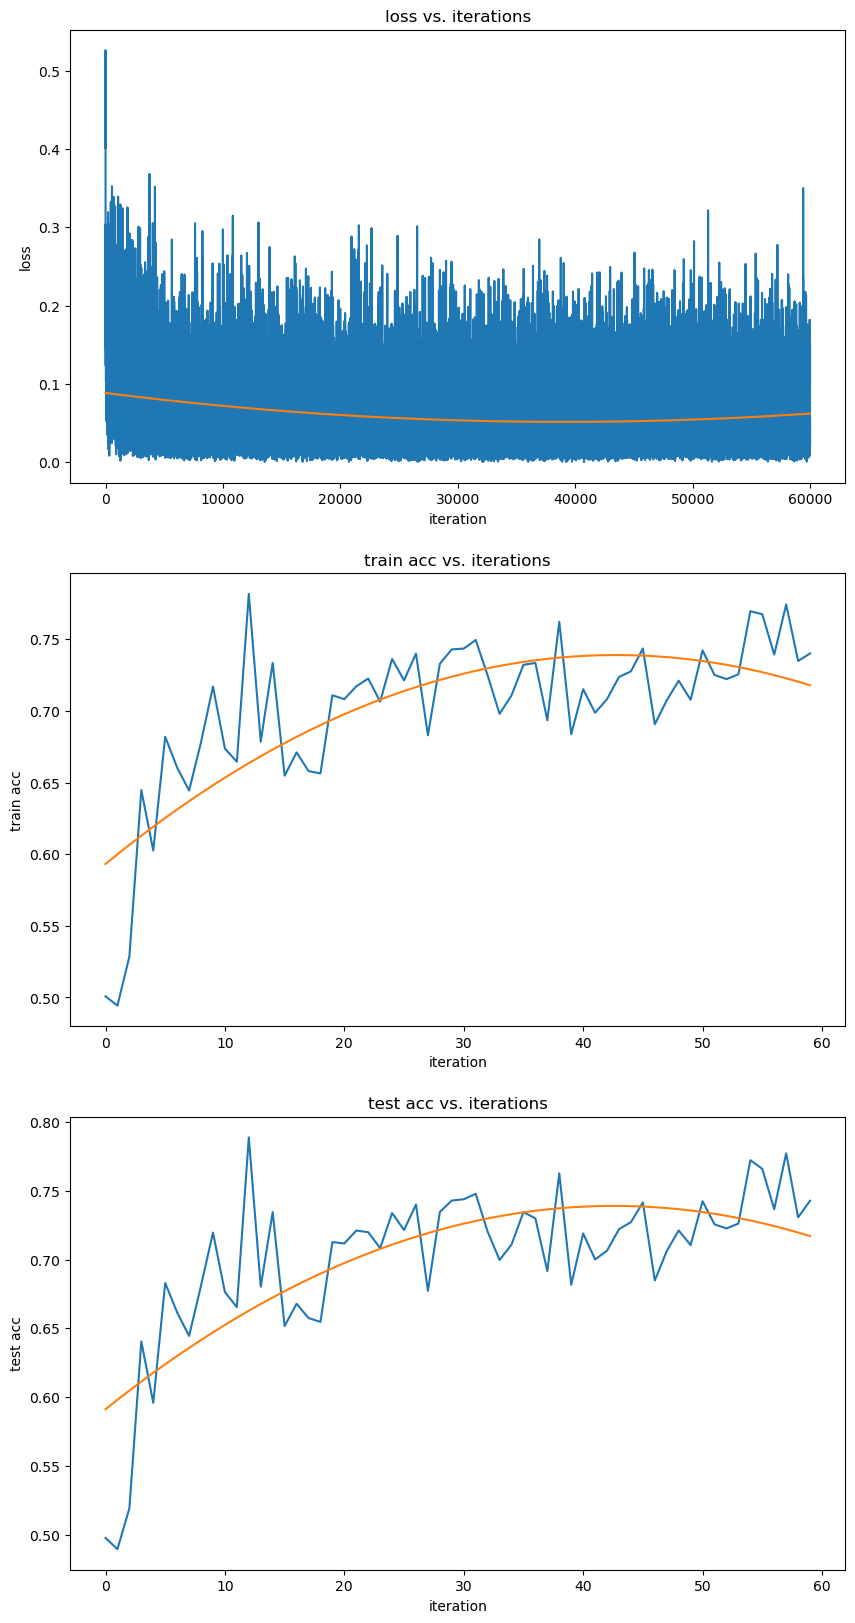

In [24]:
plot_loss_acc(running_loss_train_5_logistic, running_acc_train_5_logistic, running_acc_test_5_logistic)

In [10]:
running_loss_train_40_logistic, running_acc_train_40_logistic, running_acc_test_40_logistic = train_logistic(data, label, test_data, test_label, 40, 0.01)

epoch: 0, loss: 0.06328692376259397, acc: 0.6502694444444445, test_acc: 0.6489666666666666
epoch: 1, loss: 0.03651034758787709, acc: 0.6746111111111112, test_acc: 0.67505
epoch: 2, loss: 0.03135555473612317, acc: 0.6818194444444444, test_acc: 0.6815666666666668
epoch: 3, loss: 0.028509850716522397, acc: 0.7312083333333333, test_acc: 0.7244000000000002
epoch: 4, loss: 0.02665957594102036, acc: 0.6710222222222222, test_acc: 0.6668
epoch: 5, loss: 0.025191926741730437, acc: 0.7182527777777779, test_acc: 0.7144333333333334
epoch: 6, loss: 0.024121627252915806, acc: 0.7261333333333333, test_acc: 0.7233833333333334
epoch: 7, loss: 0.023269638438011067, acc: 0.7051472222222223, test_acc: 0.7030333333333333
epoch: 8, loss: 0.022500285242666725, acc: 0.6743277777777777, test_acc: 0.6729666666666666
epoch: 9, loss: 0.021921853925332874, acc: 0.7262972222222221, test_acc: 0.7222333333333334


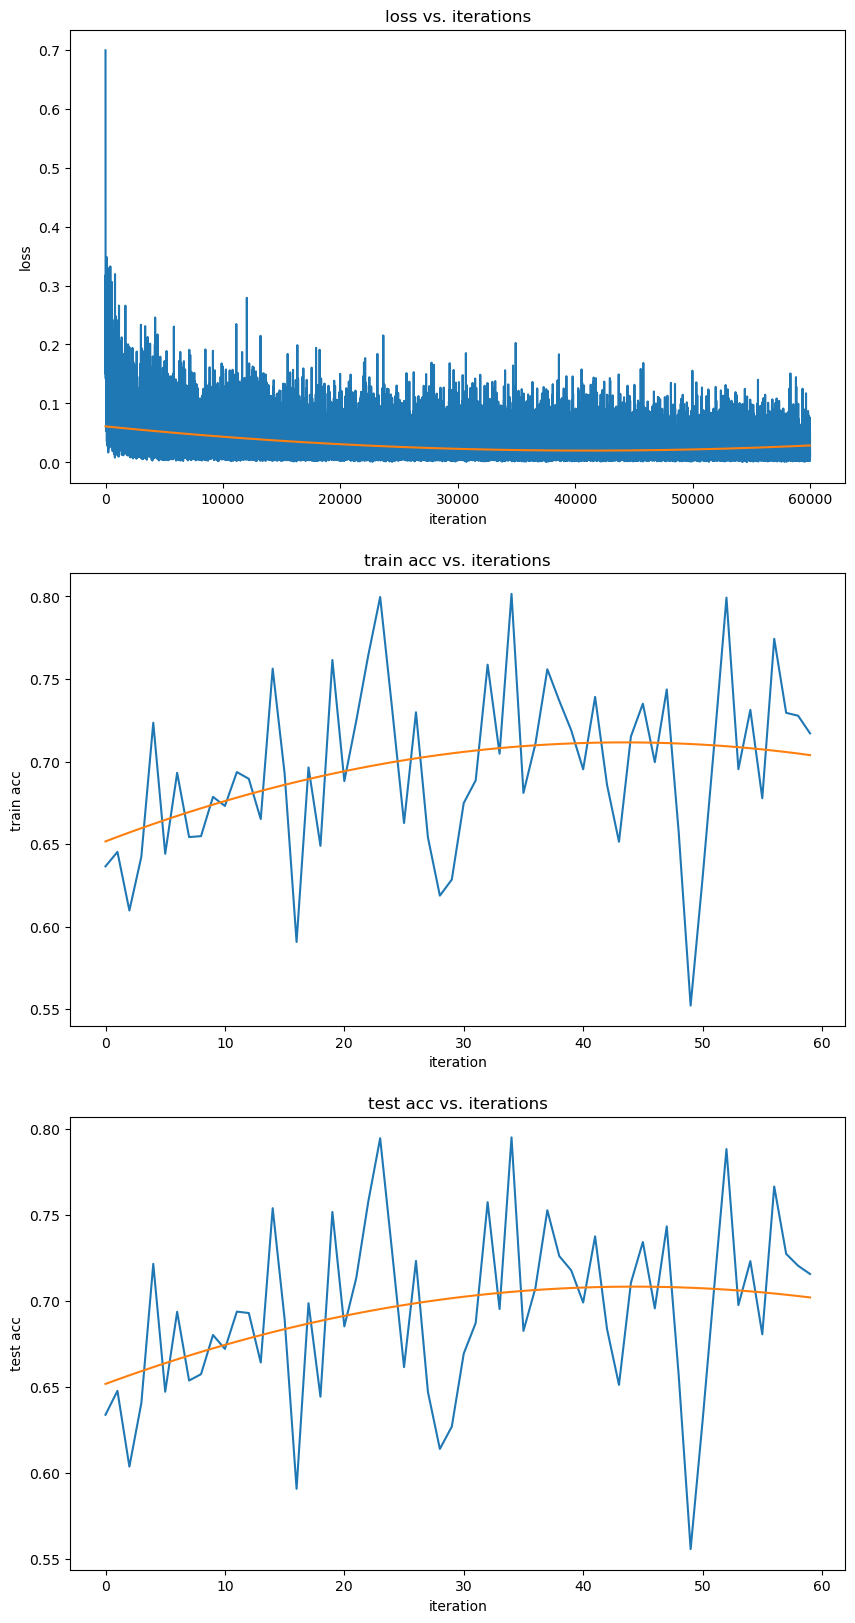

In [25]:
plot_loss_acc(running_loss_train_40_logistic, running_acc_train_40_logistic, running_acc_test_40_logistic)

In [11]:
running_loss_train_200_logistic, running_acc_train_200_logistic, running_acc_test_200_logistic = train_logistic(data, label, test_data, test_label, 200, 0.01)

epoch: 0, loss: 0.061567040691054585, acc: 0.6657388888888889, test_acc: 0.6639833333333334
epoch: 1, loss: 0.03146584752163242, acc: 0.7086444444444444, test_acc: 0.7075999999999999
epoch: 2, loss: 0.025544173913164384, acc: 0.7221805555555556, test_acc: 0.7218333333333332
epoch: 3, loss: 0.022375298070277164, acc: 0.7004250000000001, test_acc: 0.6984333333333334
epoch: 4, loss: 0.020275626741728517, acc: 0.726063888888889, test_acc: 0.7240833333333333
epoch: 5, loss: 0.018787084031875793, acc: 0.7733777777777778, test_acc: 0.7675333333333333
epoch: 6, loss: 0.017330882737961538, acc: 0.7205972222222222, test_acc: 0.7182499999999999
epoch: 7, loss: 0.016309759667687728, acc: 0.6679583333333333, test_acc: 0.6686166666666667
epoch: 8, loss: 0.015357430470029928, acc: 0.6870805555555556, test_acc: 0.6868500000000001
epoch: 9, loss: 0.014617767816778435, acc: 0.7125499999999999, test_acc: 0.7111


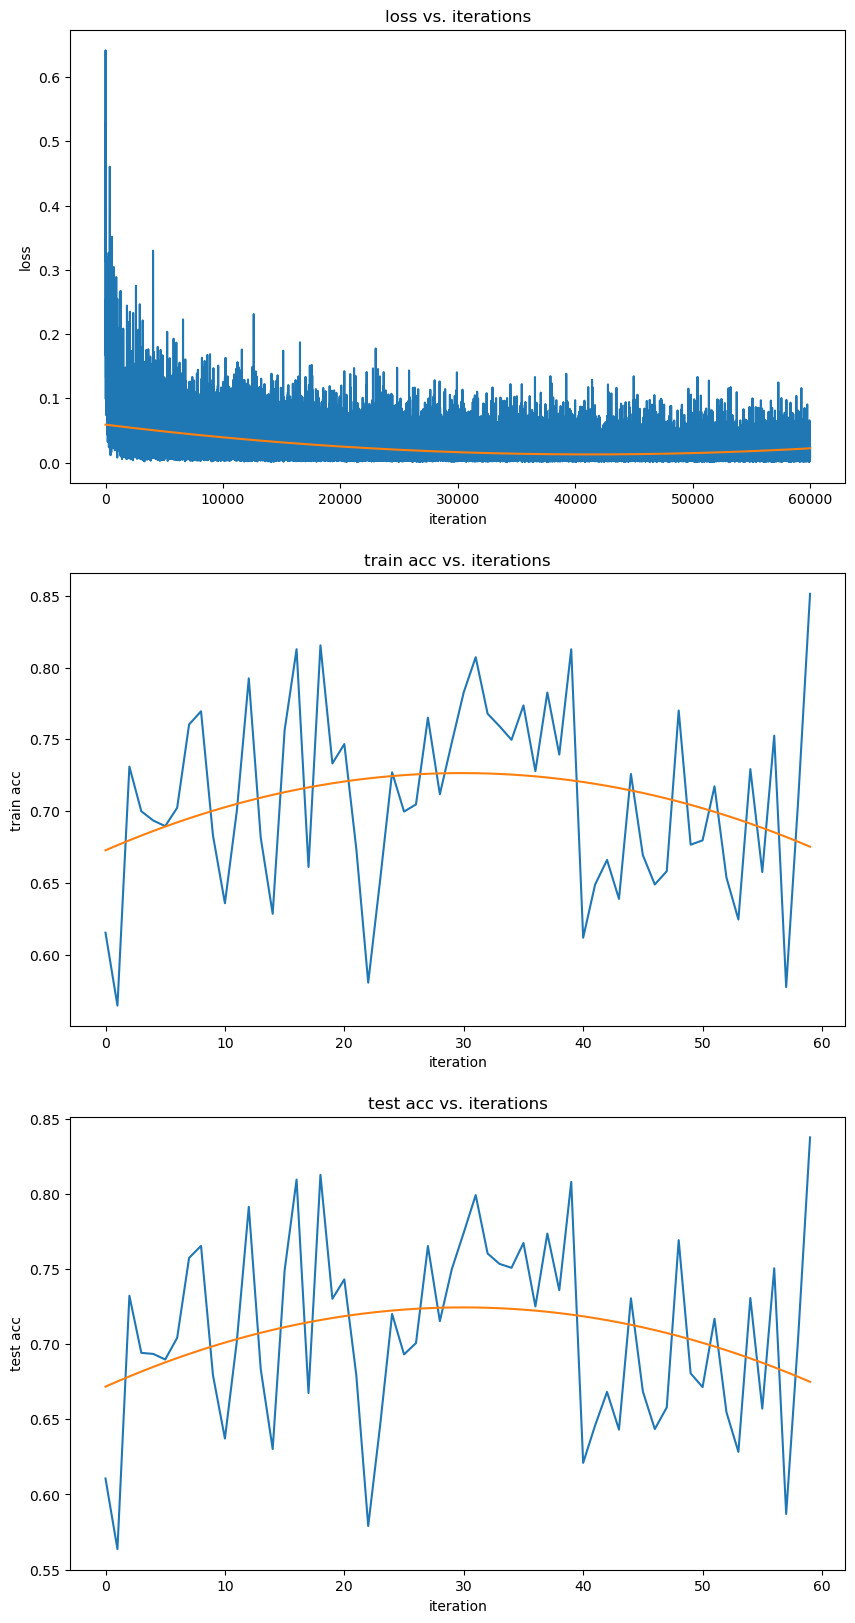

In [26]:
plot_loss_acc(running_loss_train_200_logistic, running_acc_train_200_logistic, running_acc_test_200_logistic)

# Task 5

All neural network experiments reach more accuracy than the linear model. It could be both the parameter size is increased also the non-linearity added. Moreover, by looking at the graphs, the logistic loss performs better than quadratic loss for all respected structures.